__Competition from__
https://datahack.analyticsvidhya.com/contest/job-a-thon/

# Tasks
- EDA to understand why customer respose is 0 or 1
- Predict customers response

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)

import gc

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.style.use('seaborn-whitegrid')
sns.set_palette('Set3')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from time import time, strftime, gmtime
start = time()
import datetime
print(str(datetime.datetime.now()))

/kaggle/input/jobathon-analytics-vidhya-health-insurance/sample_submission.csv
/kaggle/input/jobathon-analytics-vidhya-health-insurance/Test_data_dictionary.csv
/kaggle/input/jobathon-analytics-vidhya-health-insurance/Train_data_dictionary.csv
/kaggle/input/jobathon-analytics-vidhya-health-insurance/Train.csv
/kaggle/input/jobathon-analytics-vidhya-health-insurance/Test.csv
2021-03-15 03:48:05.842714


In [2]:
base_dir = '/kaggle/input/jobathon-analytics-vidhya-health-insurance/'

In [3]:
train = pd.read_csv(base_dir + 'Train.csv')
print(train.shape)
train.head()

(50882, 14)


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [4]:
train_dict = pd.read_csv(base_dir + 'Train_data_dictionary.csv')
train_dict

,Variable,Definition
0,ID,Unique Identifier for a row
1,City_Code,Code for the City of the customers
2,Region_Code,Code for the Region of the customers
3,Accomodation_Type,Customer Owns or Rents the house
4,Reco_Insurance_Type,Joint or Individual type for the recommended insurance
5,Upper_Age,Maximum age of the customer
6,Lower _Age,Minimum age of the customer
7,Is_Spouse,If the customers are married to each other
8,NaN,(in case of joint insurance)
9,Health_Indicator,Encoded values for health of the customer


In [5]:
test = pd.read_csv(base_dir + 'Test.csv')
print(test.shape)
test.head()

(21805, 13)


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [6]:
sub = pd.read_csv(base_dir + 'sample_submission.csv')
print(sub.shape)
sub.head()

(21805, 2)


,ID,Response
0,50883,0
1,50884,0
2,50885,0
3,50886,0
4,50887,0


# EDA

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,50882.0,25441.500000,14688.512535,1.0,12721.25,25441.5,38161.75,50882.0
Region_Code,50882.0,1732.788707,1424.081652,1.0,523.00,1391.0,2667.00,6194.0
Upper_Age,50882.0,44.856275,17.310271,18.0,28.00,44.0,59.00,75.0
Lower_Age,50882.0,42.738866,17.319375,16.0,27.00,40.0,57.00,75.0
Holding_Policy_Type,30631.0,2.439228,1.025923,1.0,1.00,3.0,3.00,4.0
Reco_Policy_Cat,50882.0,15.115188,6.340663,1.0,12.00,17.0,20.00,22.0
Reco_Policy_Premium,50882.0,14183.950069,6590.074873,2280.0,9248.00,13178.0,18096.00,43350.4
Response,50882.0,0.239947,0.427055,0.0,0.00,0.0,0.00,1.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

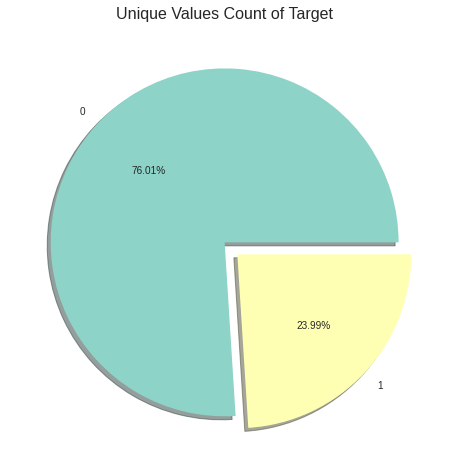

In [9]:
plt.title('Unique Values Count of Target')
plt.pie(train['Response'].value_counts().values, labels = train['Response'].value_counts().index, autopct = '%1.2f%%', 
explode = [0, 0.1], shadow = True);

__Missing values check__

features,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
total_missing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11691.000000,20251.000000,20251.000000,0.0,0.0,0.0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.976691,39.799929,39.799929,0.0,0.0,0.0


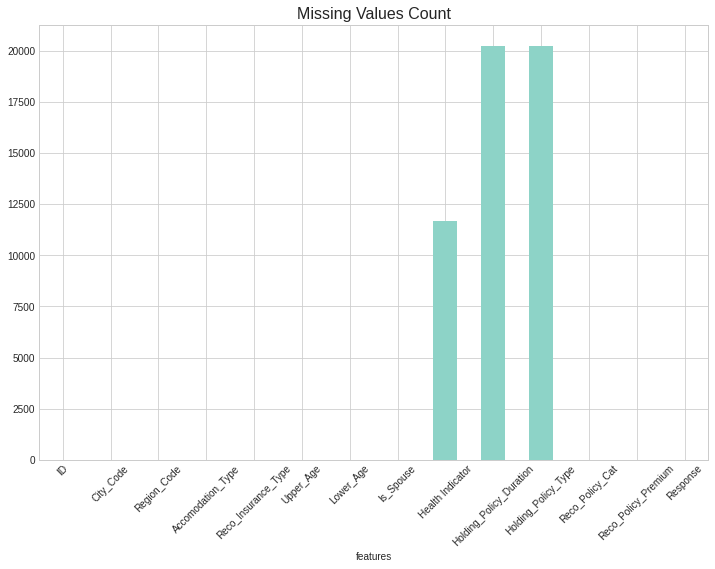

In [10]:
missing = train.isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / len(train)) * 100
missing.index = missing['features']
del missing['features']

missing['total_missing'].plot(kind = 'bar', rot = 45)
plt.title('Missing Values Count')
missing.T

- There are almost 40% values missing in 'Holding_Policy_Duration' and 'Holding_Policy_Type'
- And 23% missing in 'Health Indicator'
- How about test dataset?

features,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
total_missing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5027.000000,8603.000000,8603.000000,0.0,0.0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.054345,39.454254,39.454254,0.0,0.0


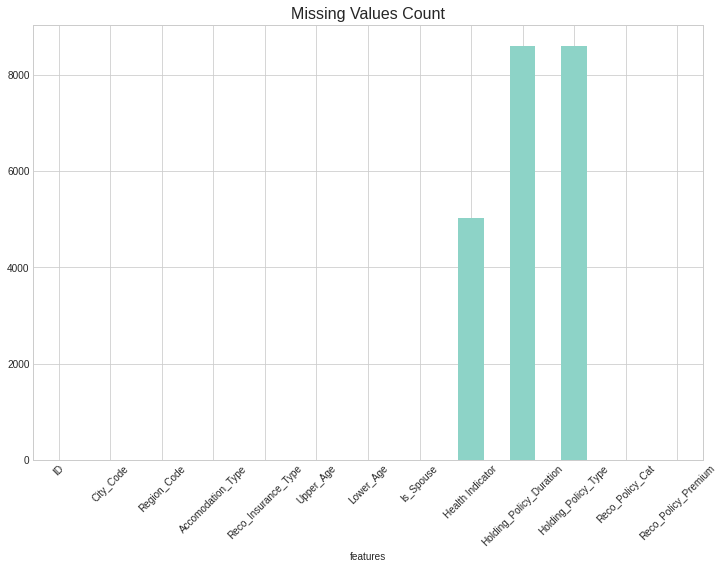

In [11]:
missing = test.isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / len(test)) * 100
missing.index = missing['features']
del missing['features']

missing['total_missing'].plot(kind = 'bar', rot = 45)
plt.title('Missing Values Count')
missing.T

- Same percentage of values missing test too
- We should Impute these missing values
- Let's check the unqiue values of these features

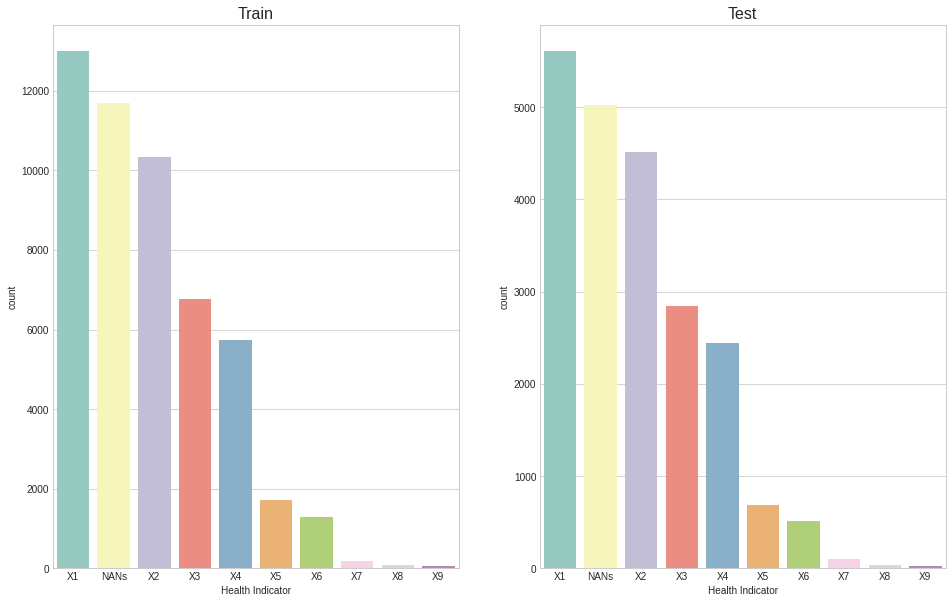

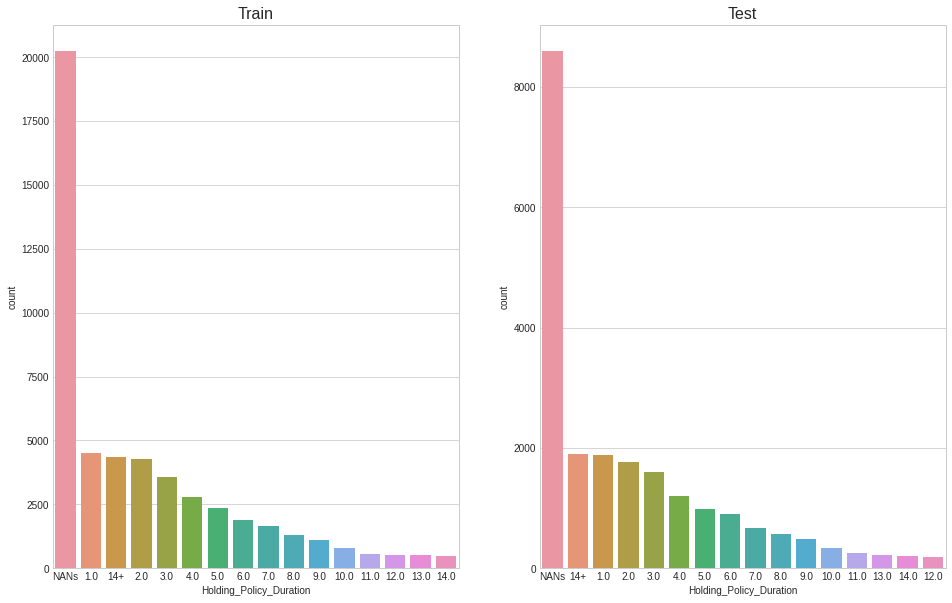

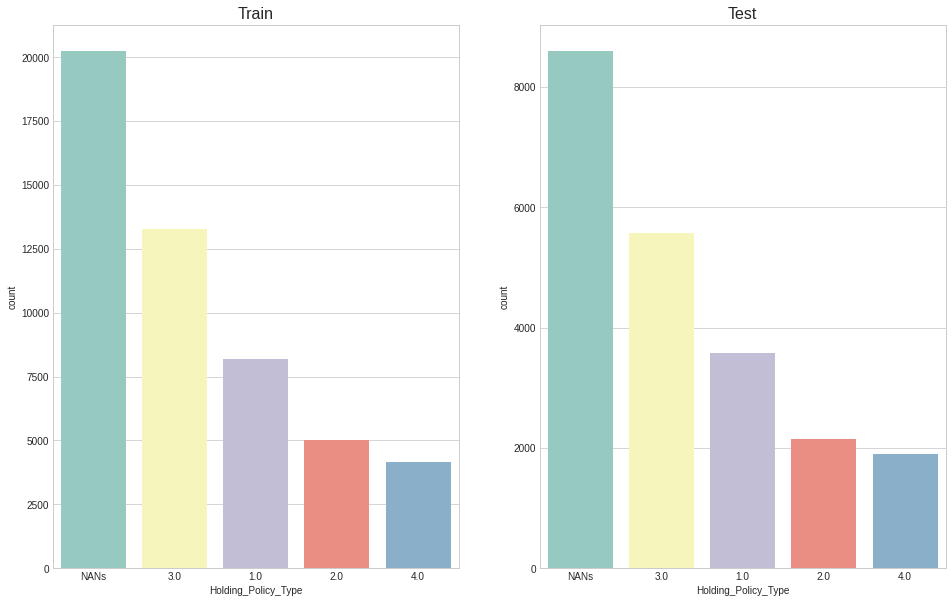

In [12]:
for i, c in enumerate(['Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type']):
    fig, ax = plt.subplots(1, 2, figsize = (16, 10))
    ax = ax.flatten()
    temp1, temp2 = train[[c]].fillna('NANs'), test[[c]].fillna('NANs')
    ax[0].set_title(f'Train')
    sns.countplot(data = temp1, x = c, ax = ax[0], order = temp1[c].value_counts().index)
    ax[1].set_title(f'Test')
    sns.countplot(data = temp2, x = c, ax = ax[1], order = temp2[c].value_counts().index)
    plt.show();

__Outliers check__

5363

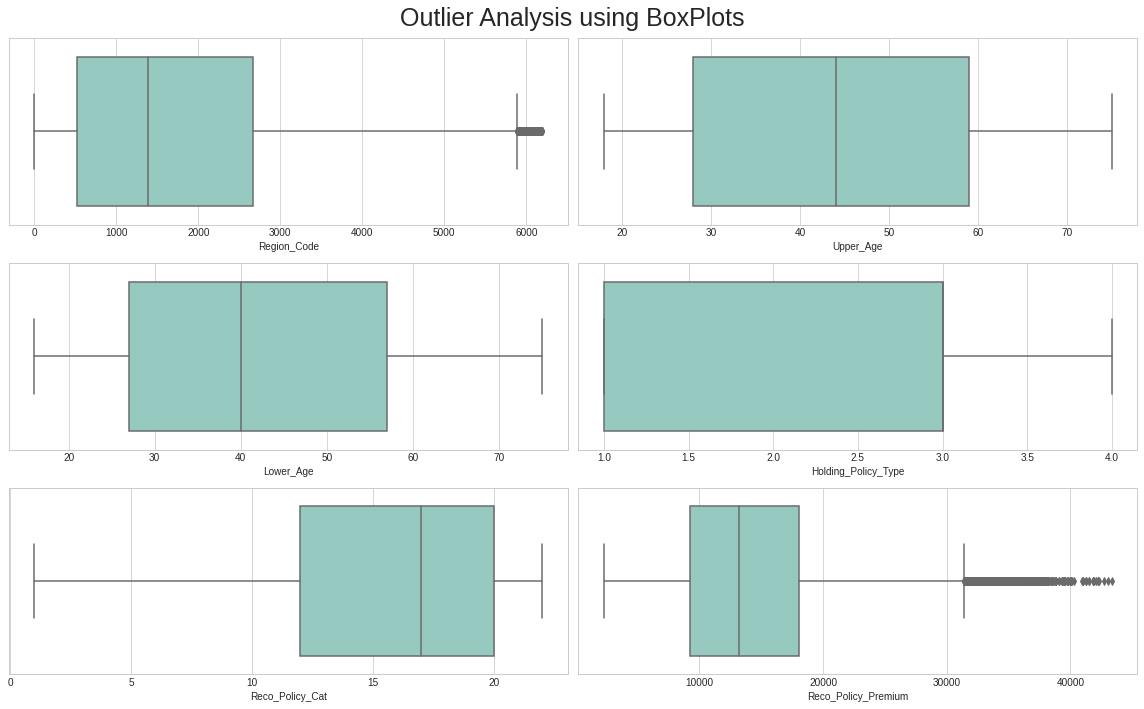

In [13]:
cols_to_check = [c for c in train.columns if (train[c].dtype != 'object') & (c not in ['ID', 'Response'])]
#cols_to_check.__len__()

fig, ax = plt.subplots(int(len(cols_to_check) / 2), 2, figsize = (16, 10))
ax = ax.flatten()

for i, c in enumerate(cols_to_check):
    sns.boxplot(x = train[c], ax = ax[i])
plt.suptitle('Outlier Analysis using BoxPlots', fontsize = 25)
fig.tight_layout()

del cols_to_check
gc.collect()

- The outlier in Reco_Policy_Premium is inherent to the data, we needn't do anything
- Region_Code is a categorical feature

__Imputing NaNs__

- Usual strategy to impute the  categorical feature is with the most frequent value and the numerical feature with mean of the feature
- Missing values in 'Holding_Policy_Type' could be construed as customers who don't have any policy yet (which is common in India) which corresponds to no value in 'Health Indicator'
- So we create a value type '0.0' for the missing NaNs in 'Holding_Policy_Type' which means they don't have a policy currently and 'X0' for 'Health Indicator' which means 'Not Known'
- Before imputing the numerical feature 'Holding_Policy_Duration', the value '14+' should be changed to a numerical value, let's make it as 14.0

In [14]:
print('Imputing Train..')
train['Health Indicator'] = train['Health Indicator'].fillna('X0')
train['Holding_Policy_Type'] = train['Holding_Policy_Type'].fillna(0.0)

train['Holding_Policy_Duration'] = train['Holding_Policy_Duration'].replace('14+', str(14.0)).astype(float)
train['Holding_Policy_Duration'] = train['Holding_Policy_Duration'].fillna(train['Holding_Policy_Duration'].mean())

print('Imputing Test..')
test['Health Indicator'] = test['Health Indicator'].fillna('X0')
test['Holding_Policy_Type'] = test['Holding_Policy_Type'].fillna(0.0)

test['Holding_Policy_Duration'] = test['Holding_Policy_Duration'].replace('14+', str(14.0)).astype(float)
test['Holding_Policy_Duration'] = test['Holding_Policy_Duration'].fillna(test['Holding_Policy_Duration'].mean())

train.isna().sum().sum(), test.isna().sum().sum()

Imputing Train..
Imputing Test..


(0, 0)

- Customers Count by City Code

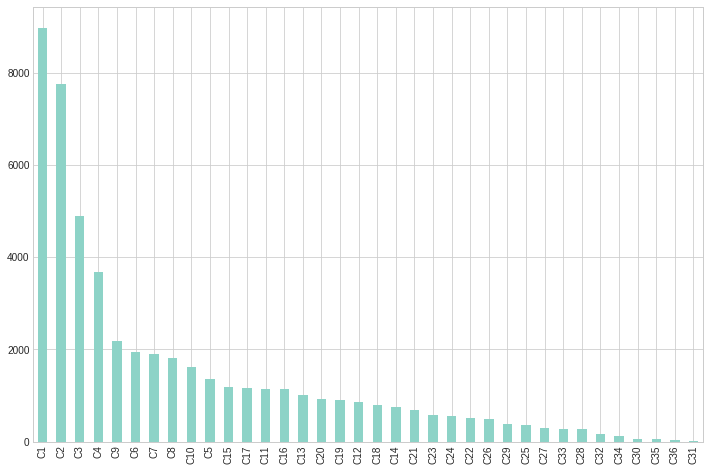

In [15]:
train['City_Code'].value_counts().plot(kind = 'bar');

- How many customers are residing in Own/Rented premises?

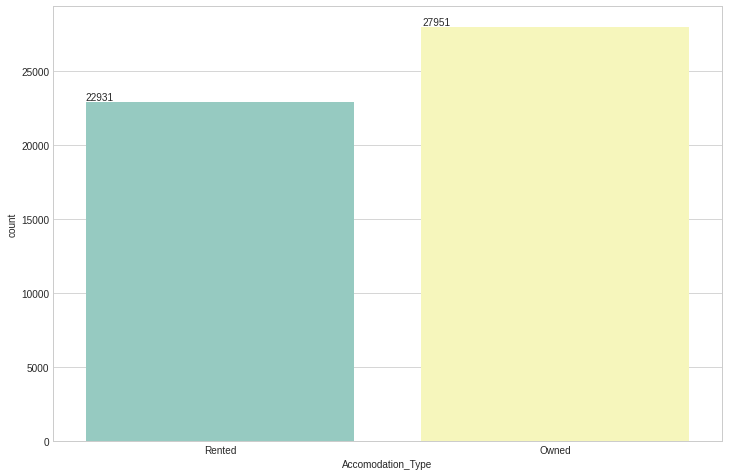

In [16]:
ax = sns.countplot(data = train, x = 'Accomodation_Type');
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- How many of the customers are holding Individual/Joint Insurance?

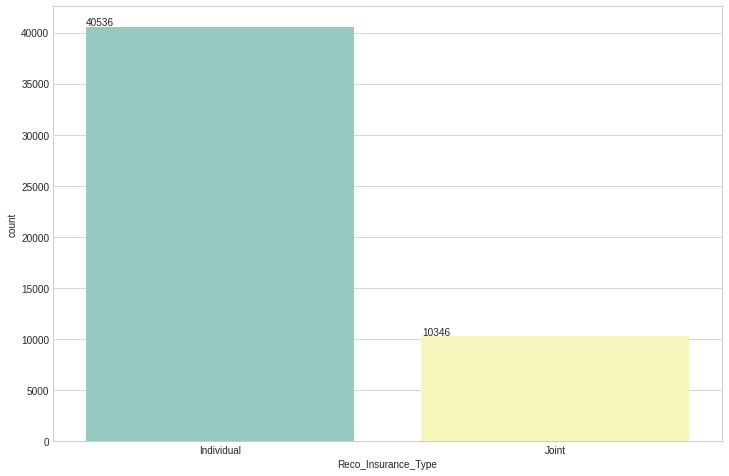

In [17]:
ax = sns.countplot(data = train, x = 'Reco_Insurance_Type');
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- How many of the customers holding Joint insurance type with Spouse/Others?

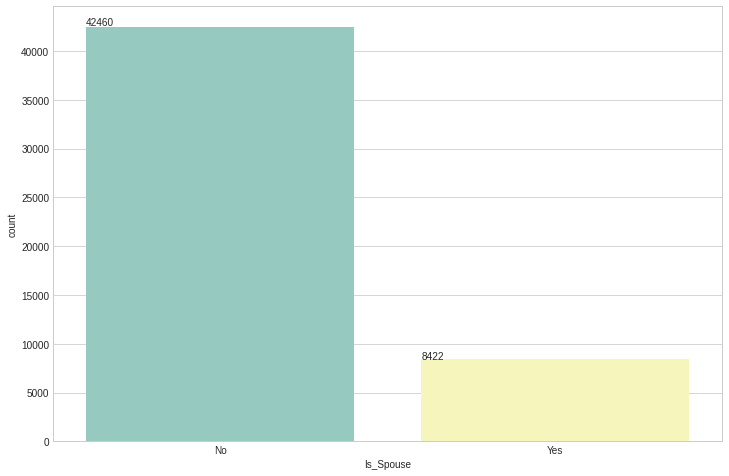

In [18]:
ax = sns.countplot(data = train, x = 'Is_Spouse');
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- What is the policy type held by customers currently?

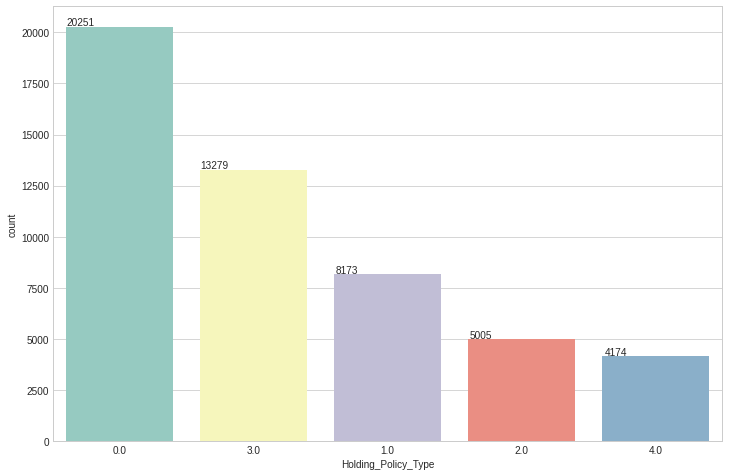

In [19]:
ax = sns.countplot(data = train, x = 'Holding_Policy_Type', order = train['Holding_Policy_Type'].value_counts().index);
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- What are the Recommended policy types?

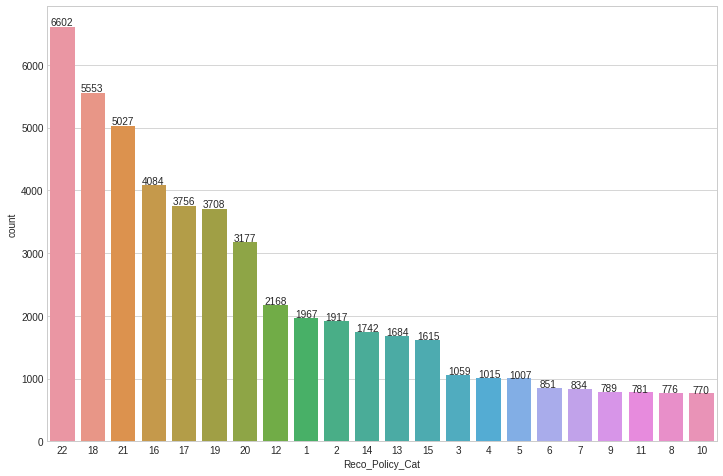

In [20]:
ax = sns.countplot(data = train, x = 'Reco_Policy_Cat', order = train['Reco_Policy_Cat'].value_counts().index);
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- Health Indicator of the customers

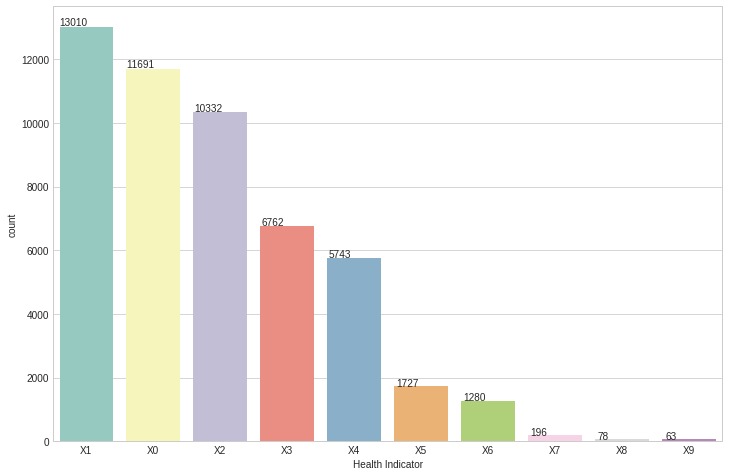

In [21]:
ax = sns.countplot(data = train, x = 'Health Indicator', order = train['Health Indicator'].value_counts().index);
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- Distribution of Recommended policy premium

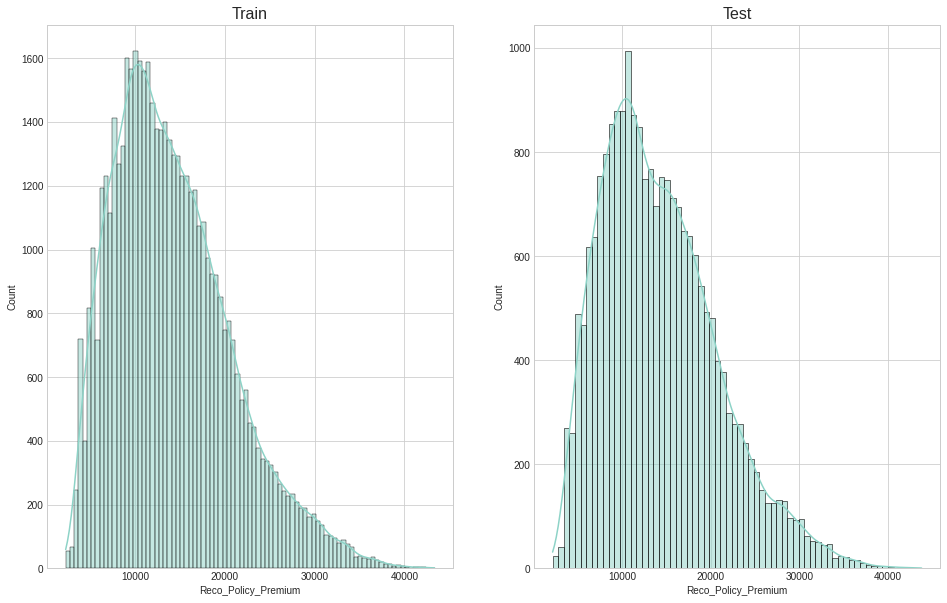

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (16, 10))
sns.histplot(data = train, x = 'Reco_Policy_Premium', kde = True, ax = ax[0])
ax[0].set_title('Train')
sns.histplot(data = test, x = 'Reco_Policy_Premium', kde = True, ax = ax[1])
ax[1].set_title('Test');

- Reco Policy Premium Boxplots of customers with Owned/Rented premises

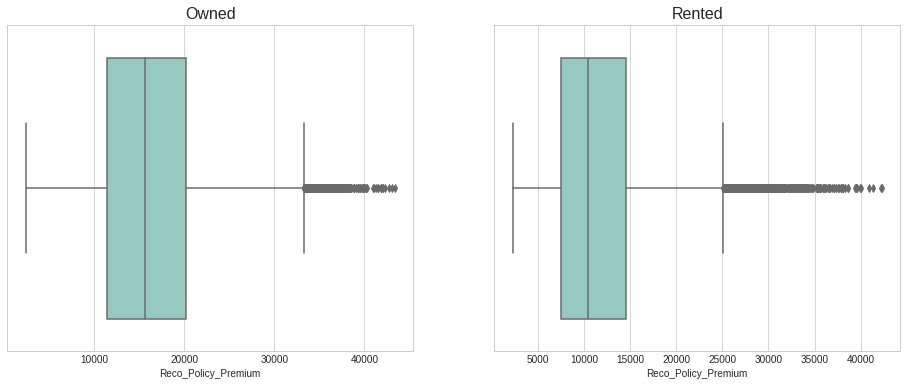

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))
sns.boxplot(data = train[train['Accomodation_Type'] == 'Owned'], x = 'Reco_Policy_Premium', ax = ax[0])
ax[0].set_title('Owned')
sns.boxplot(data = train[train['Accomodation_Type'] == 'Rented'], x = 'Reco_Policy_Premium', ax = ax[1])
ax[1].set_title('Rented');

In [24]:
train.groupby('Accomodation_Type')['Reco_Policy_Premium'].agg(['mean', 'median', 'std'])

,mean,median,std
Accomodation_Type,,,
Owned,16276.153583,15598.0,6574.536587
Rented,11633.726336,10496.0,5642.745308


- Mean and median premium is more for the cutomers with Own accomodation

- How is the Age distribution of the customers?

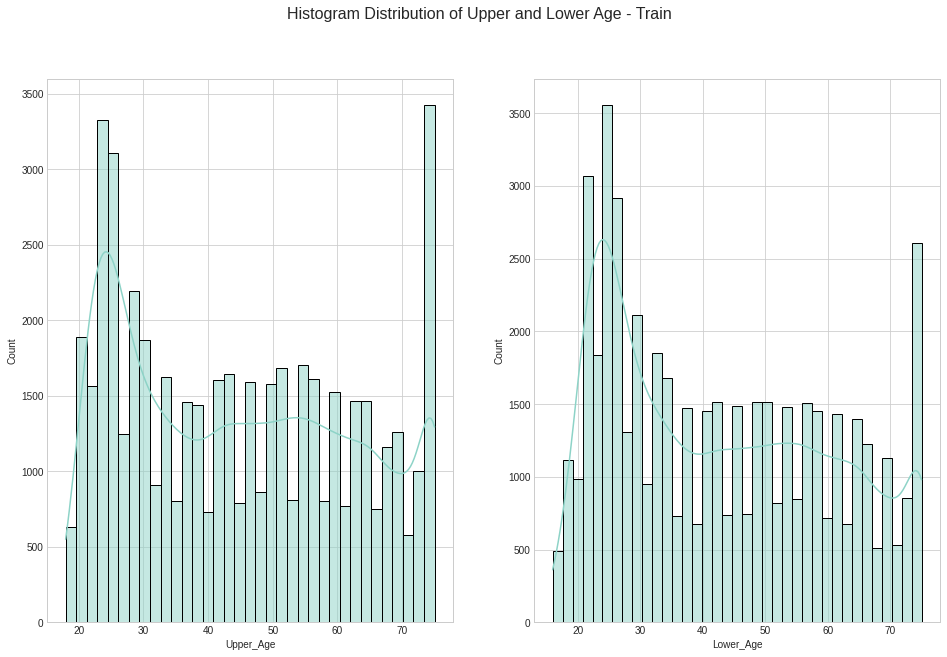

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (16, 10))
sns.histplot(data = train, x = 'Upper_Age', kde = True, ax = ax[0])
sns.histplot(data = train, x = 'Lower_Age', kde = True, ax = ax[1])
plt.suptitle('Histogram Distribution of Upper and Lower Age - Train', fontsize = 16);

In [26]:
print(f'Upper_Age - Max: {train["Upper_Age"].max()}, Min: {train["Upper_Age"].min()}')
print(f'Lower_Age - Max: {train["Lower_Age"].max()}, Min: {train["Lower_Age"].min()}')

Upper_Age - Max: 75, Min: 18
Lower_Age - Max: 75, Min: 16


In [27]:
df_age = train[['Upper_Age', 'Lower_Age']][train['Reco_Insurance_Type'] == 'Individual']
df_age['Upper_Age'].equals(df_age['Lower_Age'])

True

In [28]:
df_age = train[['Upper_Age', 'Lower_Age']][train['Reco_Insurance_Type'] == 'Joint']
df_age['Upper_Age'].equals(df_age['Lower_Age'])

False

- If the Reco_Insurance_Type is Individual then the Upper_Age and Lower_Age values are equal, if it is Joint then not equal

In [29]:
train_0, train_1 = train[train['Response'] == 0], train[train['Response'] == 1]
train_0.shape, train_1.shape

((38673, 14), (12209, 14))

__Proportion of Customers who has Owned/Rented accomodation__

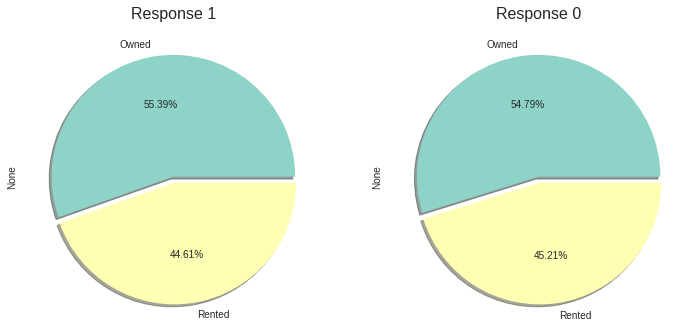

In [30]:
fig, ax = plt.subplots(1, 2)
train_1.groupby('Accomodation_Type').agg('size').plot.pie(shadow = True, autopct = '%1.2f%%', 
                                                          title = 'Response 1', explode = [0, 0.05], ax = ax[0])
train_0.groupby('Accomodation_Type').agg('size').plot.pie(shadow = True, autopct = '%1.2f%%', 
                                                          title = 'Response 0', explode = [0, 0.05], ax = ax[1]);

- The proportion of Owned/Rented accomodation are almost same for the customers responsing with 1 or 0

__Proportion of Customers who were recommended Individual or Joint Insurance__

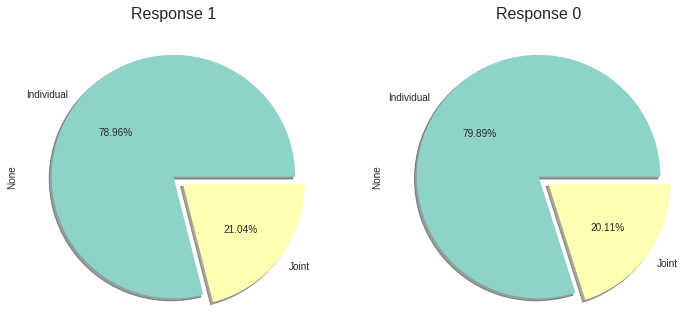

In [31]:
fig, ax = plt.subplots(1, 2)

train_1.groupby('Reco_Insurance_Type').agg('size').plot.pie(shadow = True, autopct = '%1.2f%%', 
                                                          title = 'Response 1', explode = [0, 0.1], ax = ax[0])
train_0.groupby('Reco_Insurance_Type').agg('size').plot.pie(shadow = True, autopct = '%1.2f%%', 
                                                          title = 'Response 0', explode = [0, 0.1], ax = ax[1]);

- Almost 79% of customers perefer Individual insurance type

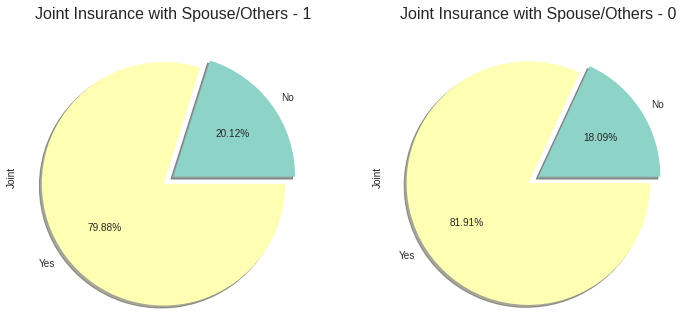

In [32]:
fig, ax = plt.subplots(1, 2)
reco_type = pd.pivot_table(data = train_1, index = 'Reco_Insurance_Type', columns = ['Is_Spouse'], aggfunc = ['size'])
reco_type.loc['Joint']['size'].plot.pie(shadow = True, autopct = '%1.2f%%', 
                                        title = 'Joint Insurance with Spouse/Others - 1', explode = [0, 0.1], ax = ax[0])
reco_type = pd.pivot_table(data = train_0, index = 'Reco_Insurance_Type', columns = ['Is_Spouse'], aggfunc = ['size'])
reco_type.loc['Joint']['size'].plot.pie(shadow = True, autopct = '%1.2f%%', 
                                        title = 'Joint Insurance with Spouse/Others - 0', explode = [0, 0.1], ax = ax[1]);

__Policy type already held by customers__

__Response 1__

In [33]:
temp = pd.pivot_table(data = train_1, index = 'Holding_Policy_Type', columns = ['Accomodation_Type', 'Reco_Insurance_Type'], 
                      values = ['ID'], 
                      aggfunc = {'ID': 'count'}) / len(train_1) * 100
temp.style.background_gradient(sns.light_palette('#2ecc71', as_cmap = True))

- The Response(1) is highest for Customers:
    - Who are in Rented accomodation
    - Who choose Individual insurance type
    - Who do not have any prior insurance policy
- Next best Response  is for Customers:
    - Who has own accocmodation
    - Chose Individual insurance type
    - Doesn't have any prior policy
- 3rd highest Response is for Customers:
    - Who has own accocmodation
    - Chose Individual insurance type
    - Who has prior policy type 3.0

- The same is observed in the table below for Response 0

__Response 0__

In [34]:
temp = pd.pivot_table(data = train_0, index = 'Holding_Policy_Type', columns = ['Accomodation_Type', 'Reco_Insurance_Type'],
               values = ['ID'], aggfunc = ['count']) / len(train_0) * 100
temp.style.background_gradient(sns.light_palette('purple', as_cmap = True))

__Mean Recommended Premium by Holding_Policy_Type, Accomodation_Type and Reco_Insurance_Type__

__Response 1__

In [35]:
temp = pd.pivot_table(data = train_1, index = 'Holding_Policy_Type', columns = ['Accomodation_Type', 'Reco_Insurance_Type'], 
                      values = ['Reco_Policy_Premium'], 
                      aggfunc = {'Reco_Policy_Premium': 'mean'})
temp.style.background_gradient(sns.light_palette('#2ecc71', as_cmap = True))

__Response 0__

In [36]:
temp = pd.pivot_table(data = train_0, index = 'Holding_Policy_Type', columns = ['Accomodation_Type', 'Reco_Insurance_Type'], 
                      values = ['Reco_Policy_Premium'], 
                      aggfunc = {'Reco_Policy_Premium': 'mean'})
temp.style.background_gradient(sns.light_palette('purple', as_cmap = True))

__Relationship between Age of policy holder with proposed Premium by Reco_Insurance_Type__

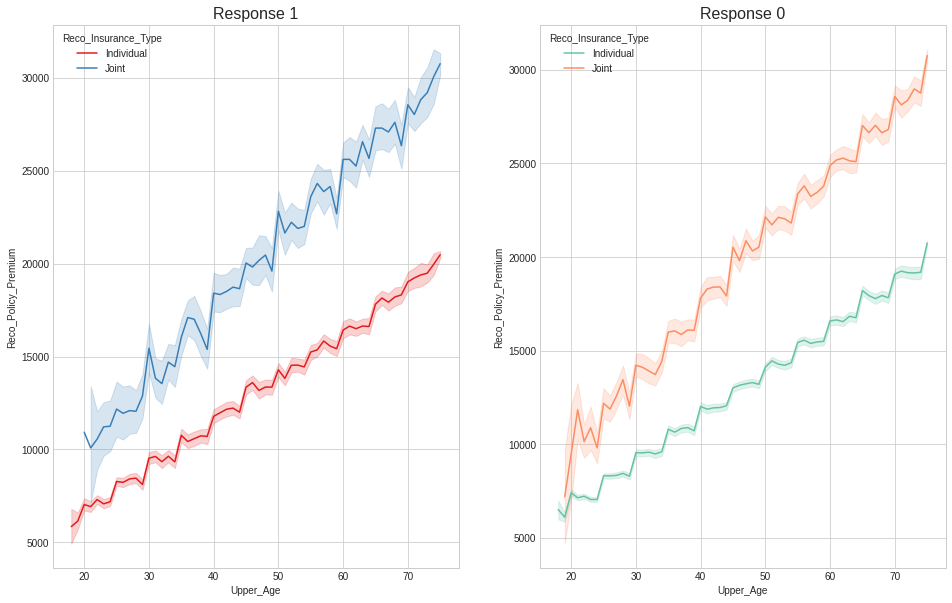

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (16, 10))
sns.lineplot(data = train_1, x = 'Upper_Age', y = 'Reco_Policy_Premium', hue = 'Reco_Insurance_Type',
             palette = 'Set1', ax = ax[0])
ax[0].set_title('Response 1')
sns.lineplot(data = train_0, x = 'Upper_Age', y = 'Reco_Policy_Premium', hue = 'Reco_Insurance_Type',
             palette = 'Set2', ax = ax[1])
ax[1].set_title('Response 0');

__Relationship between Age of policy holder with proposed Premium by Accomodation_Type__

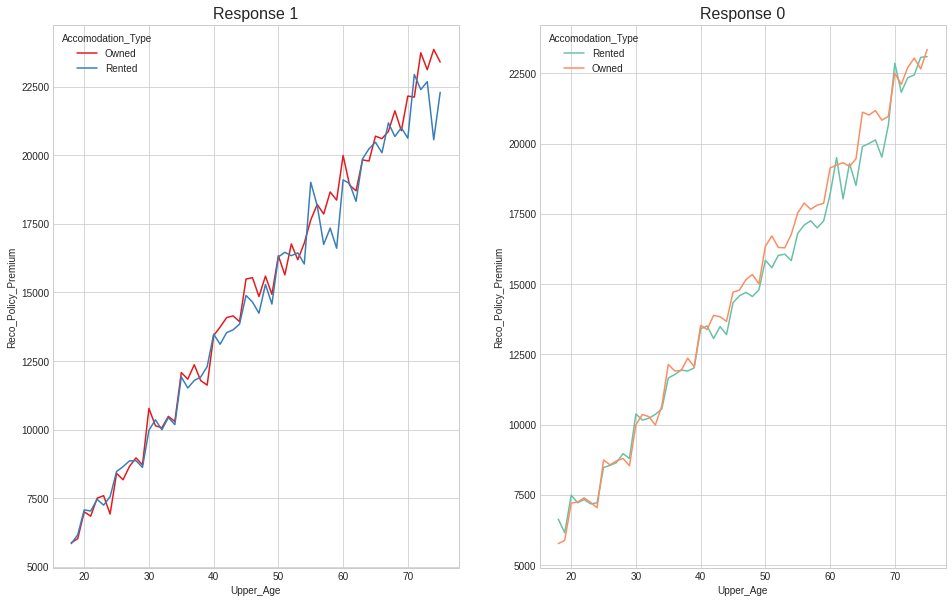

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (16, 10))
sns.lineplot(data = train_1, x = 'Upper_Age', y = 'Reco_Policy_Premium', hue = 'Accomodation_Type', ci = None,
             palette = 'Set1', ax = ax[0])
ax[0].set_title('Response 1')
sns.lineplot(data = train_0, x = 'Upper_Age', y = 'Reco_Policy_Premium', hue = 'Accomodation_Type',ci = None,
             palette = 'Set2', ax = ax[1])
ax[1].set_title('Response 0');

- Its usual that premium increases as one's age increases

__Mean Age and Premium by Customers' Health_Indicator__

__Response 1__

In [39]:
temp = pd.pivot_table(data = train_1, index = 'Health Indicator', values = ['Upper_Age', 'Reco_Policy_Premium'], aggfunc = ['mean'])
temp.style.background_gradient(sns.light_palette('#2ecc71', as_cmap = True))

__Response 0__

In [40]:
temp = pd.pivot_table(data = train_0, index = 'Health Indicator', values = ['Upper_Age', 'Reco_Policy_Premium'], aggfunc = ['mean'])
temp.style.background_gradient(sns.light_palette('purple', as_cmap = True))

__Recommended Policy Category__

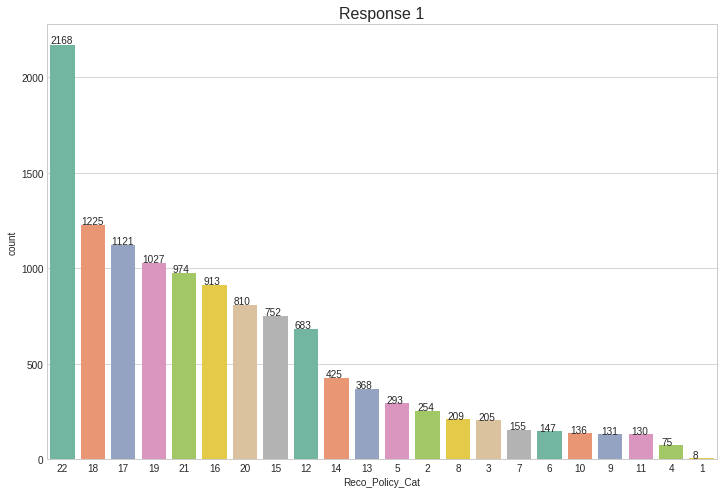

In [41]:

ax = sns.countplot(data = train_1, x = 'Reco_Policy_Cat', order = train_1['Reco_Policy_Cat'].value_counts().index, 
                palette = 'Set2')
plt.title('Response 1')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

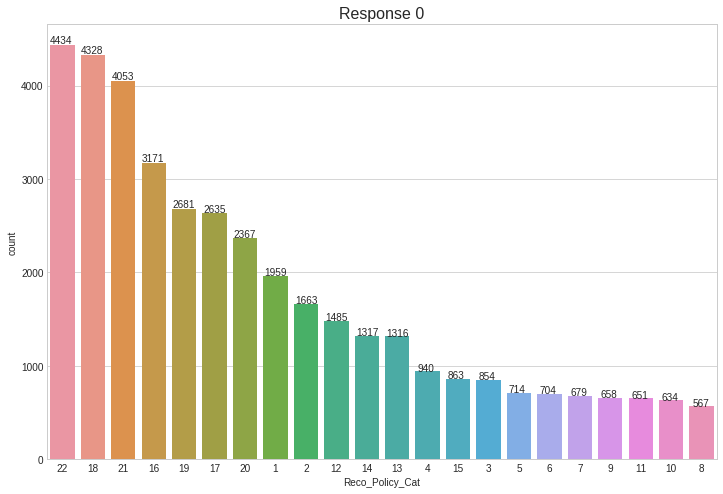

In [42]:
ax = sns.countplot(data = train_0, x = 'Reco_Policy_Cat', order = train_0['Reco_Policy_Cat'].value_counts().index)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Response 0');

- Majority of customers have chosen to respond for policy category 22
- Let's check the premium for this category

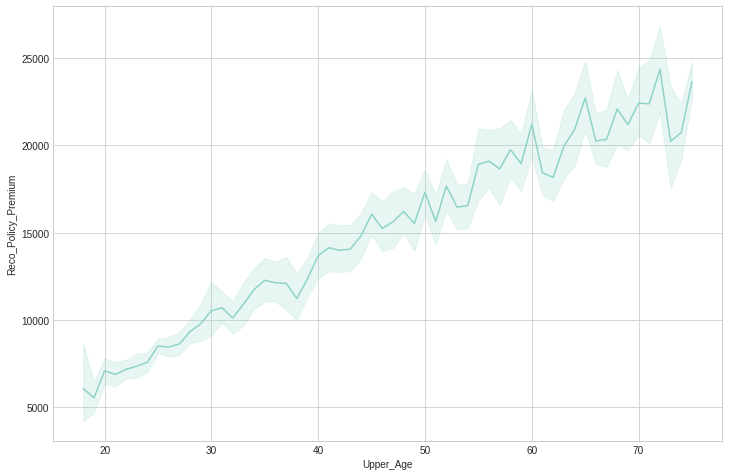

In [43]:
sns.lineplot(data = train_1[train_1['Reco_Policy_Cat'] == 22], x = 'Upper_Age', y = 'Reco_Policy_Premium');

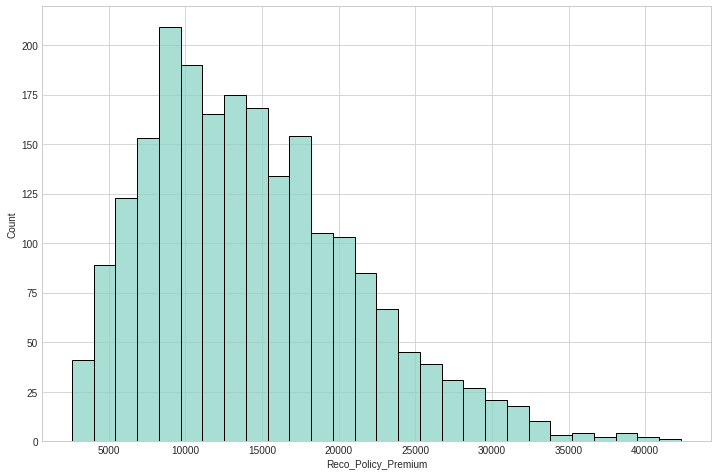

In [44]:
sns.histplot(data = train_1[train_1['Reco_Policy_Cat'] == 22], x = 'Reco_Policy_Premium');

In [45]:
print('Response 1')
print(f'Avg. premium of customers with policy category 22: {train_1[train_1["Reco_Policy_Cat"] == 22]["Reco_Policy_Premium"].mean()}')
print(f'Avg. premium of customers with policy category 18: {train_1[train_1["Reco_Policy_Cat"] == 18]["Reco_Policy_Premium"].mean()}')
print(f'Avg. premium of customers with policy category 17: {train_1[train_1["Reco_Policy_Cat"] == 17]["Reco_Policy_Premium"].mean()}')
print(f'Avg. premium of customers with policy category 1: {train_1[train_1["Reco_Policy_Cat"] == 1]["Reco_Policy_Premium"].mean()}')

Response 1
Avg. premium of customers with policy category 22: 14464.905073800737
Avg. premium of customers with policy category 18: 15399.768326530615
Avg. premium of customers with policy category 17: 15641.884924174843
Avg. premium of customers with policy category 1: 16424.7


In [46]:
print('Response 0')
print(f'Avg. premium of customers with policy category 22: {train_0[train_0["Reco_Policy_Cat"] == 22]["Reco_Policy_Premium"].mean()}')
print(f'Avg. premium of customers with policy category 18: {train_0[train_0["Reco_Policy_Cat"] == 18]["Reco_Policy_Premium"].mean()}')
print(f'Avg. premium of customers with policy category 17: {train_0[train_0["Reco_Policy_Cat"] == 17]["Reco_Policy_Premium"].mean()}')
print(f'Avg. premium of customers with policy category 1: {train_0[train_0["Reco_Policy_Cat"] == 1]["Reco_Policy_Premium"].mean()}')

Response 0
Avg. premium of customers with policy category 22: 14506.55358592692
Avg. premium of customers with policy category 18: 14455.02195009243
Avg. premium of customers with policy category 17: 14622.764478178357
Avg. premium of customers with policy category 1: 13008.722307299644


- Let's check the features which are influential in deciding Response

In [47]:
train.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

In [48]:
cat_cols = [c for c in train.columns if train[c].dtype == 'object']
num_cols = [c for c in train.columns if (c not in cat_cols) & (c != 'Response')]
cat_cols, num_cols

(['City_Code',
  'Accomodation_Type',
  'Reco_Insurance_Type',
  'Is_Spouse',
  'Health Indicator'],
 ['ID',
  'Region_Code',
  'Upper_Age',
  'Lower_Age',
  'Holding_Policy_Duration',
  'Holding_Policy_Type',
  'Reco_Policy_Cat',
  'Reco_Policy_Premium'])

__Standardize Num Features and Label Encode Cat Features__

In [49]:
scl = StandardScaler()
train[num_cols] = scl.fit_transform(train[num_cols])
test[num_cols] = scl.transform(test[num_cols])

In [50]:
for c in cat_cols: 
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].astype(str).values) + list(test[c].astype(str).values)) #Takes care of cardinality mismatch
    train[c] = lbl.transform(list(train[c].astype(str).values))
    test[c] = lbl.transform(list(test[c].astype(str).values))

In [51]:
num_pos_samples = train['Response'].value_counts().values[1]
total_samples = len(train)
scale_pos_weight = 100 - ( (num_pos_samples / total_samples) * 100 )
scale_pos_weight

76.00526708855784

In [52]:
num_pos_samples = train['Response'].value_counts().values[1]
num_neg_samples = train['Response'].value_counts().values[0]
num_neg_samples / num_pos_samples

3.1675812924891473

In [53]:
import lightgbm as lgbm

params = {'num_leaves': 1023,  # 2^max_depth - 1
          'min_child_samples': 100,
          'objective': 'binary',
          #'scale_pos_weight': scale_pos_weight, #99,
          'is_unbalance': 'true',
          'max_depth': 10,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.7,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'seed': 2021
         }

In [54]:
X = train.drop('Response', axis = 1)
y = train['Response'].copy()

In [55]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size = 0.25, random_state = 2021)
print(Xtrain.shape, ytrain.shape, Xvalid.shape, yvalid.shape)

(38161, 13) (38161,) (12721, 13) (12721,)


In [56]:
print(f'Training LightGBM..')
ltrain = lgbm.Dataset(Xtrain, label = ytrain)
lvalid = lgbm.Dataset(Xvalid, label = yvalid)

num_rounds = 10000
clf = lgbm.train(params, ltrain, num_rounds, valid_sets = [ltrain, lvalid], verbose_eval = 50, 
                    early_stopping_rounds = 100)
valid_preds = clf.predict(Xvalid, num_iteration = clf.best_iteration)
print('ROC_AUC_SCORE: ', roc_auc_score(yvalid, valid_preds))

test_preds = clf.predict(test, num_iteration = clf.best_iteration)
print(test_preds[:10])

Training LightGBM..
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.716228	valid_1's auc: 0.657394
[100]	training's auc: 0.727964	valid_1's auc: 0.661765
[150]	training's auc: 0.736282	valid_1's auc: 0.663161
[200]	training's auc: 0.744694	valid_1's auc: 0.664614
[250]	training's auc: 0.752972	valid_1's auc: 0.663862
[300]	training's auc: 0.762642	valid_1's auc: 0.664336
[350]	training's auc: 0.773402	valid_1's auc: 0.66379
Early stopping, best iteration is:
[275]	training's auc: 0.757919	valid_1's auc: 0.664792
ROC_AUC_SCORE:  0.6647921661529094
[0.50190402 0.47147077 0.55595607 0.44641687 0.46518    0.42591232
 0.57571983 0.50479071 0.5316124  0.56272161]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

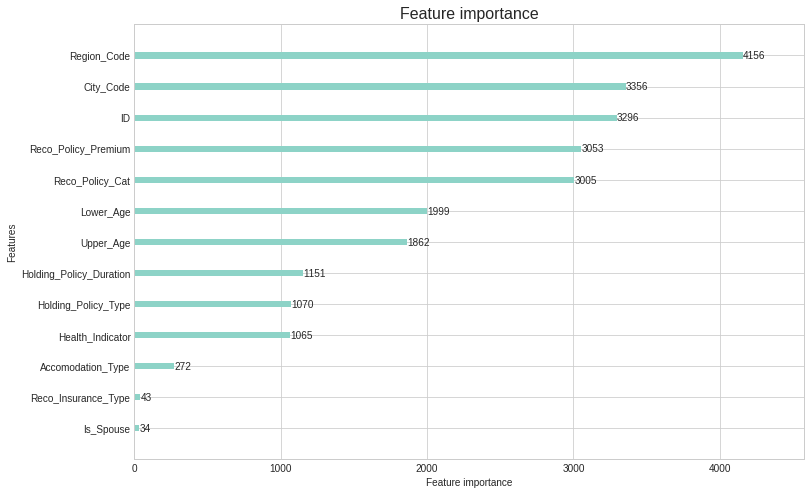

In [57]:
lgbm.plot_importance(clf)

In [58]:
from xgboost import XGBClassifier
import xgboost as xgb

xgb_params = {
         'booster': 'gbtree',
         'objective': 'binary:logistic',
         'lambda': 0.0030282073258141168, 
         'alpha': 0.01563845128469084,
         'colsample_bytree': 0.55,
         'subsample': 0.7,
         'learning_rate': 0.015,
         'max_depth': 9,
         'random_state': 2021, 
         'min_child_weight': 20,
         'gamma': 0.1,
         'alpha': 0.2,
         'lambda': 9,
         'colsample_bytree': 0.2,
         'subsample': 0.8,
         'eval_metric': 'auc',
         'seed': 2020,
         'scale_pos_weight': num_neg_samples / num_pos_samples
         }

In [59]:
xg_train = xgb.DMatrix(Xtrain, label = ytrain)
xg_valid = xgb.DMatrix(Xvalid, label = yvalid)

xgboost = xgb.train(xgb_params,
                          xg_train,
                          10000,
                          verbose_eval = 100,
                          evals = [(xg_train, 'train'), (xg_valid, 'valid')],
                          early_stopping_rounds = 100)
xpreds = xgboost.predict(xgb.DMatrix(test))
print(xpreds[:10])

[0]	train-auc:0.53332	valid-auc:0.50097
[100]	train-auc:0.72171	valid-auc:0.63204
[200]	train-auc:0.72300	valid-auc:0.63813
[300]	train-auc:0.72671	valid-auc:0.63765
[349]	train-auc:0.73230	valid-auc:0.63648
[0.4976635  0.4476396  0.45513338 0.38205805 0.42433476 0.4106051
 0.49173272 0.4422102  0.4935747  0.4985948 ]


__Classic feature importance plots__
- Note differences between the plots below
- To have a better understanding of the feature importances we should go for SHAP values

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

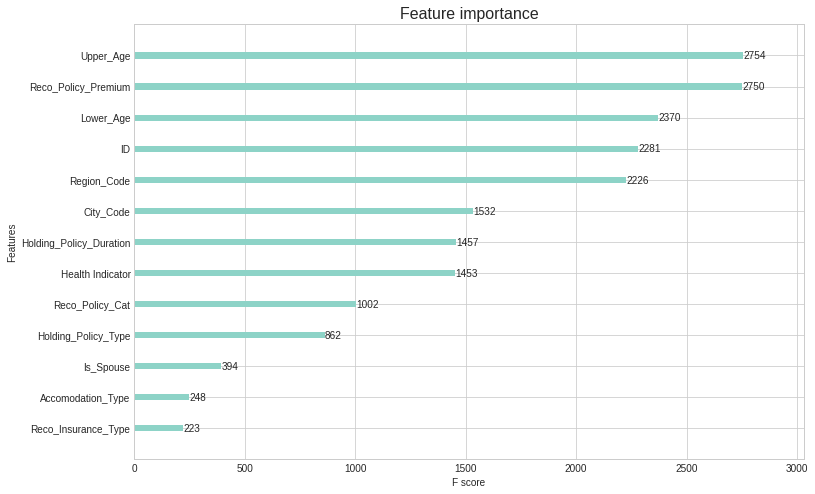

In [60]:
xgb.plot_importance(xgboost)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

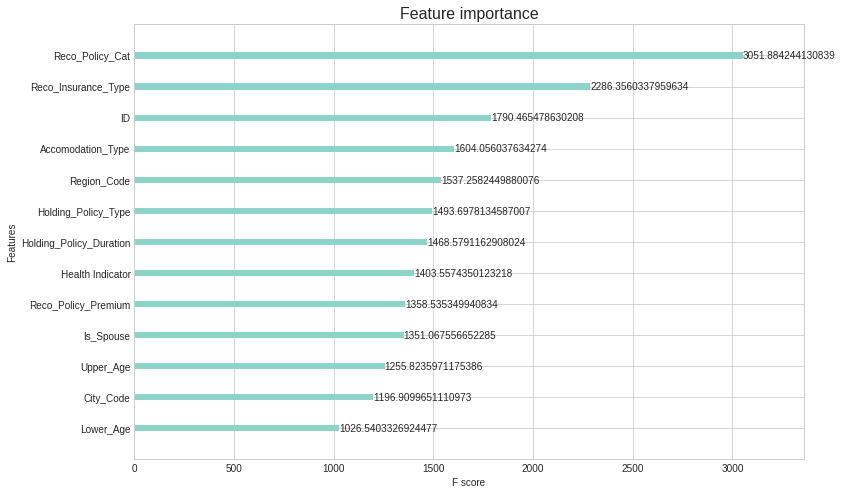

In [61]:
xgb.plot_importance(xgboost, importance_type = 'cover')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

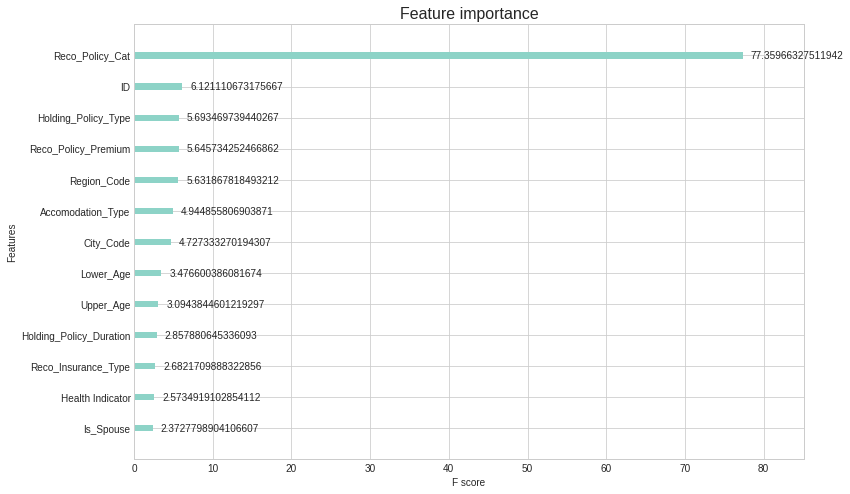

In [62]:
xgb.plot_importance(xgboost, importance_type = 'gain')

In [63]:
import shap

shap.initjs()

In [64]:
#LGBM
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(Xvalid)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


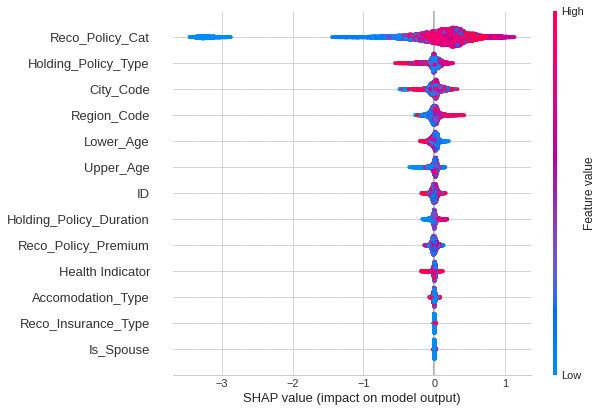

In [65]:
shap.summary_plot(shap_values[1], Xvalid)

- Higher values of Reco_Policy_Cat influences positive response
- Reco_Insurance_Type and Is_Spouse has been ignored by the model in deciding the output (while xgboost has taken into account Is_Spouse as seen from below plots)
- Lower Upper_Age results in negative response, also for Holding_Policy_Type and City_Code

In [66]:
#Shap for XGBoost
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer.shap_values(Xvalid)

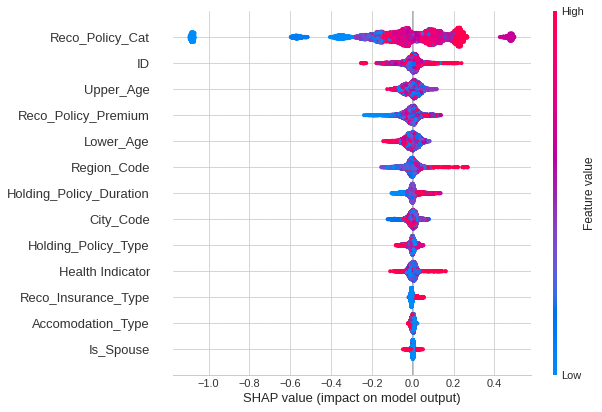

In [67]:
shap.summary_plot(shap_values, Xvalid)

In [68]:
shap.force_plot(explainer.expected_value, shap_values[1], Xvalid.iloc[0, :])

- Features in red color influence positively, i.e. drag the prediction value closer to 1, features in blue color - the opposite
- Reco_Policy_Cat is the most influential feature for the output to be 1
- Each arrow’s size represents the magnitude of the corresponding feature’s effect
- The “base value” marks the model’s average prediction over the training set

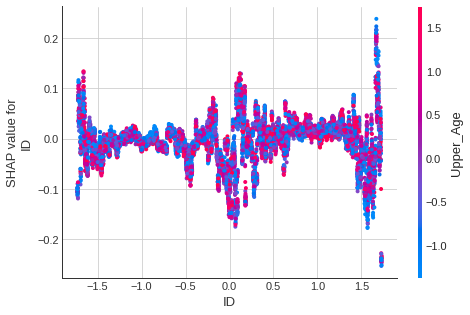

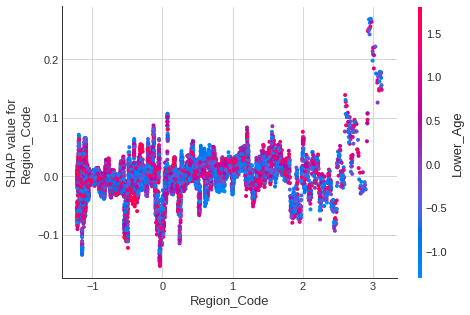

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


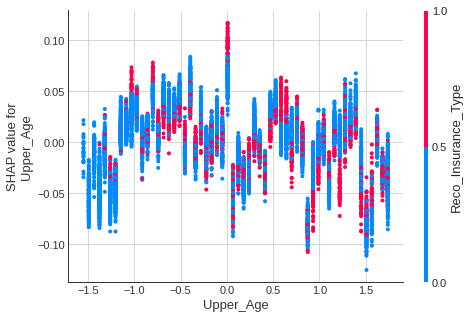

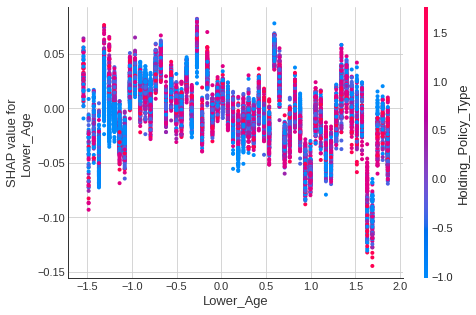

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


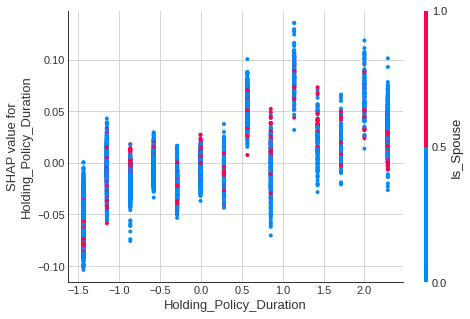

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


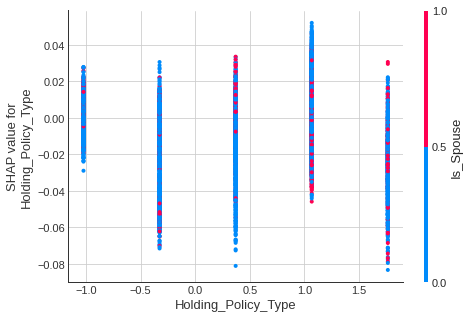

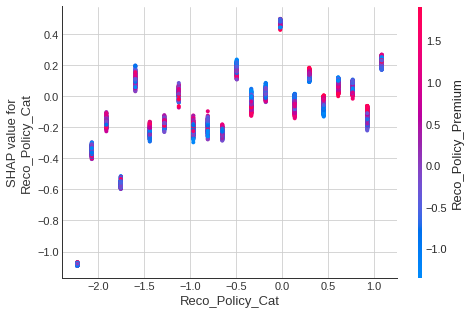

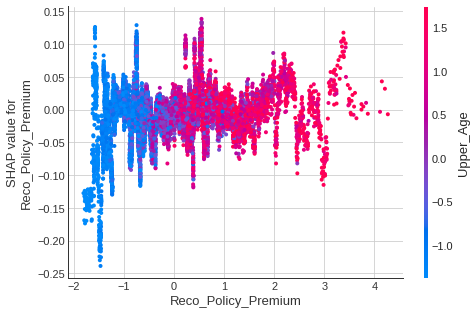

In [69]:
for name in train[num_cols].columns:
    shap.dependence_plot(name, shap_values, Xvalid)

- Dependence Plot tells whether the relationship between the target and the variable is linear, monotonic, or more complex
- The feature for which we plotted dependence plot iteracts with the feature name on the right side of the plot
- Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction
- If the slope of plot trends upward it indicates that higher values of that particular feature increases the model's prediction to be 1

In [70]:
finish = time()
print(strftime("%H:%M:%S", gmtime(finish - start)))

00:02:25
